In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import sklearn
import joblib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/export_clean_IA.csv')
interesting_columns =['SOG','COG','Heading', 'LON', 'LAT']
data_clustering = data[interesting_columns].copy()
#Vérifier que les colonnes sont numériques
for col in data_clustering.columns:
    if data_clustering[col].dtype == 'object':
        try:
            data_clustering[col] = pd.to_numeric(data_clustering[col], errors='raise')
        except ValueError:
            print(f"Colonne {col} n'est pas numérique, conversion en float64.")

print("\nDonnées pour le clustering :")
print(data_clustering.head())
print("\nTypes de données pour le clustering :")
print(data_clustering.info())
print("\nNouvelles dimensions du DataFrame pour le clustering :", data_clustering.shape)    
#Mise à l'échelle des données
scaler = preprocessing.StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_clustering), columns=interesting_columns)


Données pour le clustering :
    SOG    COG  Heading       LON       LAT
0  13.4  227.6      227 -89.29958  29.07019
1   0.0    0.0        0 -89.97235  29.25456
2   7.1   51.4      511 -92.20613  29.75368
3   0.0    0.0        0 -82.63027  27.77637
4  11.3  333.1      511 -94.77660  29.33010

Types de données pour le clustering :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289411 entries, 0 to 289410
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   SOG      289411 non-null  float64
 1   COG      289411 non-null  float64
 2   Heading  289411 non-null  int64  
 3   LON      289411 non-null  float64
 4   LAT      289411 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 11.0 MB
None

Nouvelles dimensions du DataFrame pour le clustering : (289411, 5)


# Apprentissage non-supervisé

### 1. METHODE KMEANS

Dans un premier temps nous allons déterminer la valeur de k optimale

D'où le K optimal dans notre cas est la valeur K = 3 car la courbe commence à s'aplatir. Bien que la diminution continue, le "genou" ou le point d'inflexion le plus marqué, où le bénéfice marginal d'ajouter un cluster supplémentaire diminue fortement, semble se situer à K=3. La courbe devient nettement moins pentue après ce poin

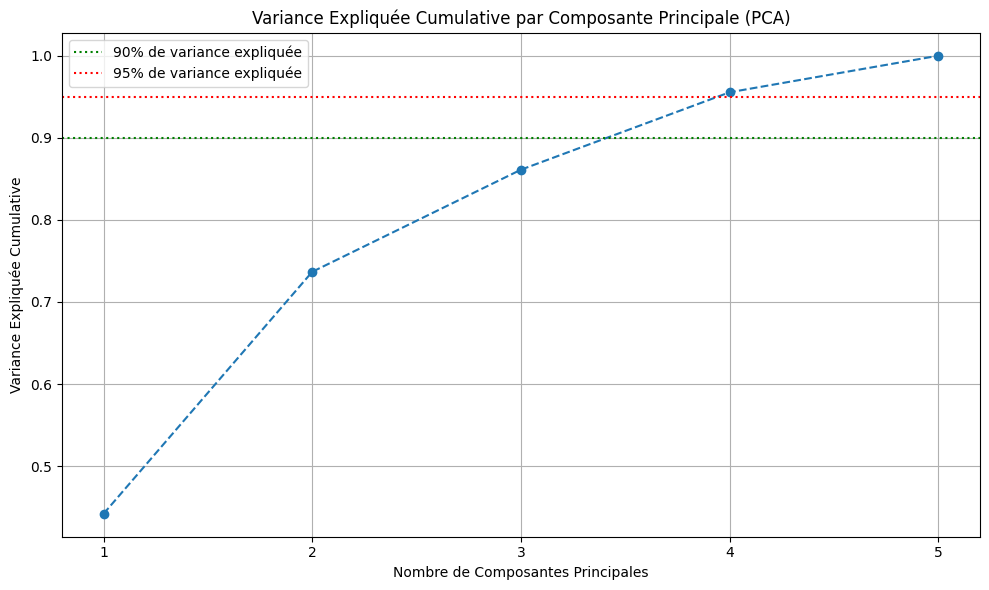

Graphique de la variance expliquée par PCA sauvegardé sous 'pca_explained_variance_schema.png'.


In [ ]:
pca_analysis = PCA()
pca_analysis.fit(data_scaled)
explained_variance_ratio_cumulative = np.cumsum(pca_analysis.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='--')
plt.title('Variance Expliquée Cumulative par Composante Principale (PCA)')
plt.xlabel('Nombre de Composantes Principales')
plt.ylabel('Variance Expliquée Cumulative')
plt.xticks(range(1, len(explained_variance_ratio_cumulative) + 1))
plt.axhline(y=0.90, color='g', linestyle=':', label='90% de variance expliquée') # Cible 90%
plt.axhline(y=0.95, color='r', linestyle=':', label='95% de variance expliquée') # Ligne indicative pour 95%
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('pca_explained_variance_schema.png')
plt.show()
print("Graphique de la variance expliquée par PCA sauvegardé sous 'pca_explained_variance_schema.png'.")

In [4]:
pca = PCA(n_components=4, random_state=42)
data_pca_reduced = pca.fit_transform(data_scaled)

-----------------------------------------
Alogorithme KMeans
-----------------------------------------



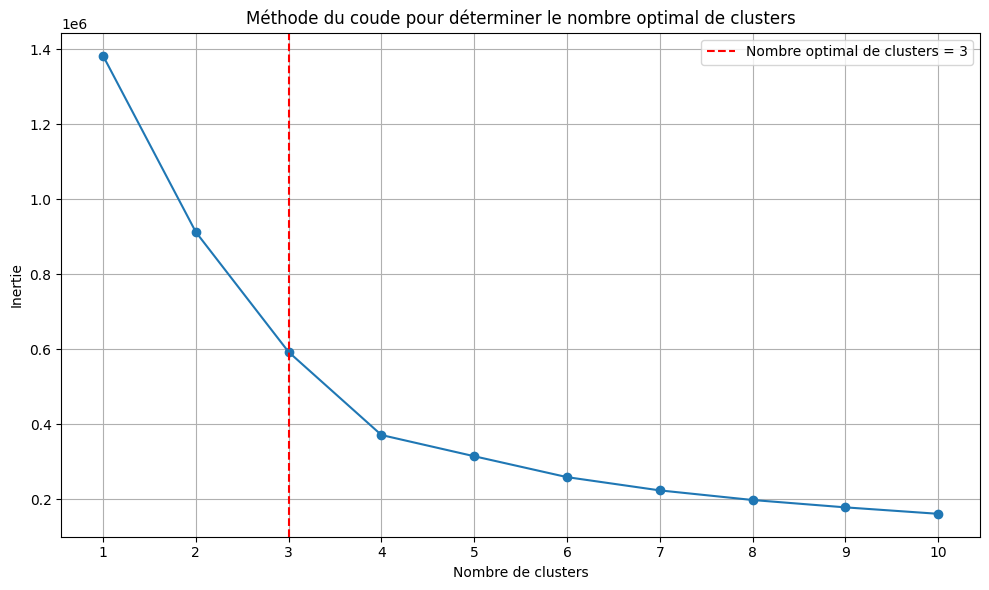

In [5]:
#Réduction de dimension avec PCA pour visualisation
print("-----------------------------------------") 
print("Alogorithme KMeans") 
print("-----------------------------------------\n")

#Détermination du nombre optimal de clusters avec la méthode du coude
inertias_pca = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data_pca_reduced)
    kmeans.fit(data_pca_reduced)
    inertias_pca.append(kmeans.inertia_)
# Affichage de la courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias_pca, marker='o')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.xticks(range(1, 11))
plt.grid(True)
plt.axvline(x=3, color='r', linestyle='--', label='Nombre optimal de clusters = 3')
plt.legend()
plt.tight_layout()
plt.savefig('elbow_method.png')
plt.show()

In [ ]:
n_clusters = 3
print(f"\nApplication de l'algorithme K-Means avec {n_clusters} clusters...\n")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
data_clustering['Cluster'] = kmeans.fit_predict(data_pca_reduced)
print(data_clustering.head())
#Analyse des résultats du clustering
print("\nAnalyse des résultats du clustering :")
cluster_summary = data_clustering.groupby('Cluster').mean()
print(cluster_summary)
# Affichage de la taille des clusters
print("\nTaille des clusters :")
print(data_clustering['Cluster'].value_counts().sort_index())
# Affichage des résultats du clustering
plt.figure(figsize=(10, 6))
plt.scatter(data_clustering['LON'], data_clustering['LAT'], c=data_clustering['Cluster'], cmap='viridis', marker='o', s=10, alpha=0.6)
plt.title(f'Clustering K-Means avec {n_clusters} clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig('kmeans_clustering.png')
plt.show()
# Sauvegarde du modèle KMeans
joblib.dump(kmeans, 'kmeans_model.pkl')

# Affichage des métriques de clustering
# Sauvegarde des données de clustering  
data_clustering.to_csv('data_clustering_with_clusters.csv', index=False)

# Sauvegarde du modèle PCA
joblib.dump(pca, 'pca_model.pkl')

Distribution des autres caractéristiques

In [ ]:
plt.figure(figsize=(13,10))
plt.scatter(data_pca_reduced[:, 0], data_pca_reduced[:, 1], c=data_clustering['Cluster'], cmap='viridis', marker='o', s=10, alpha=0.6)
plt.title('Visualisation des données après PCA avec 4 composantes')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_4_components_visualization.png')
plt.axis('off')
plt.colorbar()

### 2. METHODE DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
import seaborn as sns
min_samples = 10  # Minimum number of samples for a cluster
print(f"\nApplication de l'algorithme DBSCAN avec min_samples={min_samples}...\n")
# Calcul de la distance maximale pour le voisinage
neighbors = sklearn.neighbors.NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(data_scaled)
distances, indices = neighbors_fit.kneighbors(data_scaled)
# Tri des distances pour la courbe de distance
distances = np.sort(distances[:, min_samples - 1], axis=0)
# Affichage de la courbe de distance
plt.figure(figsize=(12, 6))
plt.plot(distances, marker='o')
plt.title('Courbe de distance pour DBSCAN')
plt.xlabel('Points triés')
plt.ylabel('Distance')
plt.grid(True)
plt.axhline(y=0.21, color='r', linestyle='--', label='Valeur seuil pour DBSCAN')
plt.tight_layout()
plt.savefig('dbscan_distance_curve.png')
plt.show()

# METRIQUES POUR APPRENTISSAGE NON-SUPERVISE

In [ ]:
import plotly.express as px
px.set_mapbox_access_token('pk.eyJ1Ijoicm9sbGludGF5aSIsImEiOiJjbWMybDFuMTgwOXhhMmxzZHNpcXlidnY2In0.A-oJhjFocH47TsX6y63A-g')
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
data_clean = data.loc[data_clustering.index].copy()
data_clean.loc[:, 'Cluster'] = kmeans.labels_
data_clean['Cluster'] = data_clean['Cluster'].astype(str)
#data_sample = data_clean.sample(n=75000, random_state=42)

print("\nCréation de la carte intéractive avec Plotly...\n")
fig = px.scatter_mapbox(
    data_clean,
    lat='LAT',
    lon='LON',
    color='Cluster',  
    hover_name='VesselName',
    hover_data=['SOG', 'COG','Heading','Cluster','VesselType'],
    zoom=3,
    height=700,
    title='Trajectoires des navires avec Clustering K-Means',
    mapbox_style='carto-positron',
    color_discrete_sequence = px.colors.qualitative.Plotly
)
#Afficher la figure interactive
fig.show()
# #Ajout des trajectoires des navires
# print("\nAjout des trajectoires des navires à la carte...\n")
# unique_mmsi = data_clean['MMSI'].unique()[:5]  # Limiter à 5 navires pour la clarté
# for mmsi in unique_mmsi:
#     ship_data = data_clean[data_clean['MMSI'] == mmsi]
#     fig.add_trace(go.Scattermapbox(
#         lat=ship_data['LAT'],
#         lon=ship_data['LON'],
#         mode='lines+markers',
#         name=f'MMSI {mmsi}',
#         line=dict(width=1),
#         marker=dict(size=2),
#         hoverinfo='text',
#         hovertext=f'MMSI: {mmsi}<br>SOG: {ship_data["SOG"].mean():.2f}<br>COG: {ship_data["COG"].mean():.2f}'
#     ))

# #Mise en forme de la carte
# fig.update_layout(
#     title='Trajectoires des navires avec Clustering K-Means',
#     mapbox=dict(
#         style='carto-positron',
#         zoom=10,
#         center={"lat": data_clean['LAT'].mean(), "lon": data_clean['LON'].mean()}
#     ),
#     legend_title_text='Cluster',
#     height=600,
#     width=800
# )
output_html_filename = f"{'Cluster'}_clusters_on_map_scatter_map.html"
fig.write_html(output_html_filename)
print(f"\nLa carte interactive a été sauvegardée sous '{output_html_filename}'.")

In [ ]:
joblib.dump(kmeans, 'kmeans_model.joblib')
# joblib.dump(dbscan, 'dbscan_model.joblib')
joblib.dump(scaler, 'scaler_model.joblib')